This tutorial guides you on how to train a sequence-to-sequence model to translate from Spanish to English. Second, you will embed the attention mechanism into this model. After training, you can plot a word-to-word plot showing the attention between words. The example plot is below. 

![](https://tensorflow.org/images/spanish-english.png)
Refer to Tensorflow.Org (2020).

Reference:
* Neural machine translation with attention: https://www.tensorflow.org/tutorials/text/nmt_with_attention
* Neural Machine Translation (seq2seq) Tutorial: https://github.com/tensorflow/nmt

In [0]:
#!pip install -q tf-nightly

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import os
import io

print("Tensorflow Version: {}".format(tf.__version__))
print("GPU {} available.".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.1.0
GPU is available.


# Data Preprocessing

We'll use a language dataset provided by [http://www.manythings.org/anki/](http://www.manythings.org/anki/). The dataset contains the language-translation pairs in the format `Sentence1 Translated_Sentence2`.

```text
May I borrow this book? ¿Puedo tomar prestado este libro?
```

You can download the desired dataset. After you downloaded the dataset, the following is the preprocessing step.

1. Add a `start` and an `end` token to each sequence.
2. Clean the sentences by removing special characters.
3. Create mapping dictionaries that one maps from words to indices and the other maps from indices to words.
4. To do the batch training, we need to pad each sequence to a maximum length. However, there are different strategies to do padding, for example, a better way is masking.

In [0]:
# Download the dataset
path_to_dir = tf.keras.utils.get_file('spa-eng.zip', 
                                      origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', 
                                      extract=True)

2646016/2638744 [==============================] - 0s 0us/step


In [0]:
path_to_file = os.path.join(os.path.dirname(path_to_dir), "spa-eng", "spa.txt")
assert os.path.exists(path_to_file), "File was not found."

In [0]:
# convert a file encoding from the unicode to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [0]:
def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  
  # create a space between a word and the punctuation following it
  # "This is the end." -> "This is the end ."
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with a space except (a-z, A-Z, '.', '?', '!', ',')
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.rstrip().strip()

  # add a start and a end token
  w = '<start> ' + w + ' <end>'
  return w

Let's try some examples.

In [0]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


Create a dataset with preprocessors.

In [0]:
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='utf-8').read().strip().split('\n')
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]
  return zip(*word_pairs)

In [0]:
en, sp = create_dataset(path_to_file, None)

print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


Before padding the sequences, you need to find the maximum length of sequences.

In [0]:
def max_length(tensor):
  max_tensor = None
  tmp, maxlen = 0, 0
  for t in tensor:
    tmp = len(t)
    if tmp > maxlen:
      maxlen = tmp
      max_tensor = t
  return maxlen, max_tensor

In [0]:
def tokenize(text):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(text)
  tensor = lang_tokenizer.texts_to_sequences(text)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
  return tensor, lang_tokenizer

In [0]:
def load_dataset(path, num_examples=None):
  # create cleaned input, output pairs
  # to train a model from Spanish to English,
  # the target language is English, and input language is Spanish
  targ_lang, inp_lang = create_dataset(path, num_examples)
  
  input_tensor, input_tokenizer = tokenize(inp_lang)
  target_tensor, target_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, input_tokenizer, target_tokenizer

## Limit the Size of Datasets

Before training a model on the whole dataset, you can limit the dataset size to train it faster.

In [0]:
num_examples = 30000  # you can try different numbers
input_tensor, target_tensor, input_tokenizer, target_tokenizer = load_dataset(path_to_file, num_examples)

# the max sequence length
max_length_target, max_length_input = max_length(target_tensor), max_length(input_tensor)
max_length_target, max_length_input

((11, array([ 1, 36,  3,  2,  0,  0,  0,  0,  0,  0,  0], dtype=int32)),
 (16,
  array([  1, 135,   3,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0], dtype=int32)))

In [0]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

In [0]:
print(len(input_tensor_train), len(input_tensor_val), len(target_tensor_train), len(target_tensor_val))

24000 6000 24000 6000


In [0]:
def convert(tokenizer, tensor):
  for t in tensor:
    if t != 0: print("{} --> {}".format(t, tokenizer.index_word[t]))

print("Input: Index to Word")
convert(input_tokenizer, input_tensor_train[0])
print("\nTarget: Index to Word")
convert(target_tokenizer, target_tensor_train[0])

Input: Index to Word
1 --> <start>
9 --> el
160 --> tenia
8172 --> envidia
14 --> de
19 --> mi
1803 --> exito
3 --> .
2 --> <end>

Target: Index to Word
1 --> <start>
14 --> he
4329 --> envied
21 --> my
2370 --> success
3 --> .
2 --> <end>


## Create a tf.data.Dataset

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_size_input = len(input_tokenizer.word_index) + 1
vocab_size_target = len(target_tokenizer.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))\
            .shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((64, 16), (64, 11)), types: (tf.int32, tf.int32)>

In [0]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [0]:
example_input_batch[0], example_target_batch[0]

(<tf.Tensor: shape=(16,), dtype=int32, numpy=
 array([   1,   12,  153,    9, 4529,  514, 4888,    3,    2,    0,    0,
           0,    0,    0,    0,    0], dtype=int32)>,
 <tf.Tensor: shape=(11,), dtype=int32, numpy=
 array([   1,    4,   77, 4696, 1996,    3,    2,    0,    0,    0,    0],
       dtype=int32)>)

In [0]:
''.join([input_tokenizer.index_word[n] for n in example_input_batch[8].numpy() if n != 0]), \
''.join([input_tokenizer.index_word[n] for n in example_target_batch[8].numpy() if n != 0])

('<start>tomperdiolaapuesta.<end>', '<start>?somoslaadulto.<end>')

# Write the Encoder and Decoder Model

Before embedding the attention mechanism into the seq2seq model (mainly composed of two sub-models, an encoder, and a decoder), let's take a look at the attention mechanism. Look at the below diagram, each input word taken by an encoder is assigned a weight by the attention mechanism that is used further by the decoder to predict the words in the sentence.

![](https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg)
Refer to Tensorflow.Org (2020).

More specifically, the attention mechanism provides an idea of weighting the time stamp. In an RNN model, a hidden state is a relationship between timestamps, it is generated after each iteration. First, the hidden state generated from each iteration is in the shape of `(batch_size, sequence_length, hidden_state_size)`. The attention weights are randomly initialized on the shape of `(batch_size, sequence_length)` in batch data. It expands dimensions and repeats values alongside the final axis at the hidden state to become `(batch_size, sequence_length, hidden_state_size)`. Next, multiply the hidden state matrix and expanded attention matrix to get the new matrix which contains the information of time stamps. Sum this new matrix at the axis of timestamps to summarize overall impacts at hidden states (shape becomes `(batch_size, hidden_state_size)`). Such a summarized matrix is called `context vector`. This context vector could be further passed into an activation layer (normally a Tanh layer) to become an attention vector. This attention vector is further multiplied with the hidden state of the decoder to predict the words.

More details and formulas as the below.
![](https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg)
![](https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg)
Refer to Tensorflow.Org (2020).

The pseduo-code (refer to Tensorflow.Org (2020)):

```text
FC = Fully connected (dense) layer
EO = Encoder output
H = hidden state
X = input to the decoder
```

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the 1st axis, since the shape of score is `(batch_size, max_length, hidden_size)`. Max_length is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an `embedding layer`.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU (a gated RNNCell)

Now let's build an encoder.

In [0]:
class Encoder(tf.keras.Model):
  """Define the Encoder model."""
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
    super(Encoder, self).__init__()
    self.batch_size = batch_size
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, 
                                               output_dim=embedding_dim)
    self.gru = tf.keras.layers.GRU(units=enc_units, return_sequences=True, 
                                   return_state=True, recurrent_initializer='glorot_uniform')
    
  def call(self, x, hidden):
    """
    args:
      x: (batch_size, sequence_length)
      hidden: (batch_size, enc_units)
      
    returns:
      output: (batch_size, sequence_length, enc_units)
      state: (batch_size, enc_units)
    """
    embed = self.embedding(x)
    output, state = self.gru(embed, initial_state=hidden)
    return output, state

  def initial_hidden_state(self):
    return tf.zeros((self.batch_size, self.enc_units))


encoder = Encoder(vocab_size_input, embedding_dim, units, BATCH_SIZE)

Let's try some samples.

In [0]:
# sample input
sample_hidden = encoder.initial_hidden_state()
sample_output, sample_state = encoder(example_input_batch, sample_hidden)

print('Encoder output shape (batch size, sequence length, units): {}'.format(sample_output.shape))
print('Encoder hidden state shape (batch size, units): {}'.format(sample_state.shape))

Encoder output shape (batch size, sequence length, units): (64, 16, 1024)
Encoder hidden state shape (batch size, units): (64, 1024)


Next, you are going to build a Bahdanau attention layer.

In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  """An Attention Layer"""
  def __init__(self, units):
    """Constructor
    
    args:
      units: the potential number of timestamps
    """
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    """call is the layer function
    
    args:
      query: the hidden state, (batch_size, hidden_size == encoder_units)
      values: the encoder outputs with return_sequence=True
              (batch_size, sequence_length, encoder_units)
      
    returns:
      context_vector: (batch_size, units == hidden_size)
      attention_weights: (batch_size, max_length, 1)
    """
    # hidden state shape == (batch size, hidden size)
    # to expand dimension at the time axis == (batch size, 1, hidden size)
    # perform this to calculate the score
    hidden_time_axis = tf.expand_dims(query, axis=1)
    
    # time addition (batch_size, sequence_length, units) == \
    #               (batch_size, sequence_length, units) + (batch_size, 1, units)
    # score shape == (batch size, sequence_length, 1)
    addition = tf.nn.tanh(self.W1(values) + self.W2(hidden_time_axis))
    score = self.V(addition)
    
    # attention weights shape == (batch size, sequence_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)
    
    # context vector shape after sum == (batch_size, units == hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    
    return context_vector, attention_weights

In [0]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention Result Shape (batch size, hidden size): {}".format(attention_result.shape))
print("Attention Weights Shape (batch size, sequence length, 1): {}".format(attention_weights.shape))

Attention Result Shape (batch size, hidden size): (64, 1024)
Attention Weights Shape (batch size, sequence length, 1): (64, 16, 1)


In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.batch_size = batch_size
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
    self.gru = tf.keras.layers.GRU(units=dec_units, return_sequences=True, 
                                   return_state=True, recurrent_initializer='glorot_uniform')
    self.dense = tf.keras.layers.Dense(units=vocab_size)
    self.attention = BahdanauAttention(dec_units)
    
  def call(self, x, hidden, enc_output):
    """
    args:
      x: (batch_size, 1) an input of the decoder, 
         it is generated from the previous timestamp or the encoder at the beginning
      hidden: (batch_size, encoder_units)
         the hidden state from the previous timestamp or the encoder at the beginning
      enc_output: (batch_size, sequence_length, encoder_units)
    """
    
    # the embedding features (batch_size, 1) => (batch_size, 1, embedding_dims)
    x = self.embedding(x)
    
    # context_vector: (batch_size, encoder_units == hidden_size)
    # attentions_weights: (batch_size, sequence_length, 1)
    context_vector, attention_weights = self.attention(hidden, enc_output)
    
    # (batch_size, 1, hidden_size + embedding_size)
    attention_vector = tf.concat([tf.expand_dims(context_vector, axis=1), x], axis=-1)
    
    # gru_seq: (batch_size, 1, dec_units)
    # gru_state: (batch_size dec_units)
    gru_seq, gru_state = self.gru(attention_vector)
    
    # shape: (batch_size, dec_units)
    gru_seq = tf.reshape(gru_seq, (-1, gru_seq.shape[2]))
    
    # results: (batch_size, vocab_size)
    results = self.dense(gru_seq)
    
    return results, gru_state, attention_weights

Let's try some examples passed into the decoder.

In [0]:
decoder = Decoder(vocab_size_target, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, sample_decode_hidden, sample_attention = decoder(
  tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)

print("Decoder output shape (batch_size, vocab_size): {}".format(sample_decoder_output.shape))
print("Decoder output shape (batch_size, decoder_units): {}".format(sample_decode_hidden.shape))
print("Attention Weights shape (batch_size, sequence_length, 1): {}".format(attention_weights.shape))

Decoder output shape (batch_size, vocab_size): (64, 4935)
Decoder output shape (batch_size, decoder_units): (64, 1024)
Attention Weights shape (batch_size, sequence_length, 1): (64, 16, 1)


# Define the Optimizer and the Loss Function

Here, we can address this problem (or training) as a classification issue. Further, we can use the `tf.keras.losses.SparseCategoricalCrossentropy` to calculate the loss value. In the loss function, we only calculate and add the loss of the target token.

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss = loss_object(real, pred)
    
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  return tf.reduce_mean(loss)

# Define the callback for saving models.

In [0]:
ckpt_dir = os.path.join('./train_ckpt')
ckpt_path = os.path.join(ckpt_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

# Training

The following is the basic training flow of the NMT (or the seq2seq) model.

1. Pass the input (a batch of text sequences) and an initialized hidden state into the encoder that returns encoder output and encoder statue.
2. The encoder output, encoder status and input of decoder (or a start token) are passed into the decoder that returns decoder results (or the vocabulary predictions), decoder status, and attention weights.
3. Continue passing both the decoder result and hidden status back to the decoder to generate next result.
3-1. Pass the decoder hidden status back to the decoder for the next prediction.
3-2. Use `Teacher forcing` to decide the next input to the decoder. (The `Teacher Forcing` is a method where the target word is passed as the next input to the decoder.)
4. Calculate the gradients and an optimizer applies them to the trainable variables.

In [0]:
@tf.function
def train_step(inputs, targets, enc_hidden):
  """train_step calculates the loss and apply it to variable using an optimizer"""
  loss = 0

  with tf.GradientTape() as tape:
    encoder_output, encoder_state = encoder(inputs, enc_hidden)
    
    # the hidden state from the encoder is passed into the decoder as the hidden state at the beginning
    decoder_hidden = encoder_state 
    
    # before training alongside the time axis, define the start token, (BATCH_SIZE, 1)
    decoder_inputs = tf.expand_dims([target_tokenizer.word_index['<start>']] * BATCH_SIZE, axis=-1)
    
    # the way implementing the `Teacher Forcing` method
    for t in range(1, targets.shape[1]):
      # predictions: (batch_size, vocab_size)
      predictions, decoder_hidden, _ = decoder(decoder_inputs, decoder_hidden, encoder_output)
      
      loss += loss_function(targets[:, t], predictions)
        
      # for the next timestamp
      decoder_inputs = tf.expand_dims(targets[:, t], 1)

  batch_loss = loss / int(targets.shape[1])
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    
  # TODO: why not use batch_loss
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return batch_loss

In [0]:
EPOCHS = 10

for epoch in range(EPOCHS):
    
  enc_hidden = encoder.initial_hidden_state()
  total_loss = 0.
    
  for (batch, (inputs, targets)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inputs, targets, enc_hidden)
    total_loss += batch_loss
    
    if batch % 100 == 0:
      print("Epoch {}, Batch: {}, Loss: {:.8f}".format(
        epoch, batch, batch_loss))
  
  # saving the model every 2 epochs
  if epoch % 2 == 0:
    checkpoint.save(file_prefix=ckpt_path)

  print("Epoch {}, Loss: {:.8f}".format(
    epoch+1, total_loss / steps_per_epoch))

Epoch 0, Batch: 0, Loss: 4.69906712
Epoch 0, Batch: 100, Loss: 2.25346994
Epoch 0, Batch: 200, Loss: 1.90462244
Epoch 0, Batch: 300, Loss: 1.67702401
Epoch 1, Loss: 2.04723525
Epoch 1, Batch: 0, Loss: 1.61597657
Epoch 1, Batch: 100, Loss: 1.43694174
Epoch 1, Batch: 200, Loss: 1.39408076
Epoch 1, Batch: 300, Loss: 1.21647930
Epoch 2, Loss: 1.39231980
Epoch 2, Batch: 0, Loss: 1.07960165
Epoch 2, Batch: 100, Loss: 1.06089711
Epoch 2, Batch: 200, Loss: 1.04340386
Epoch 2, Batch: 300, Loss: 0.89520407
Epoch 3, Loss: 0.97760099
Epoch 3, Batch: 0, Loss: 0.65559530
Epoch 3, Batch: 100, Loss: 0.63016272
Epoch 3, Batch: 200, Loss: 0.65117055
Epoch 3, Batch: 300, Loss: 0.68390524
Epoch 4, Loss: 0.66192865
Epoch 4, Batch: 0, Loss: 0.32427439
Epoch 4, Batch: 100, Loss: 0.47229239
Epoch 4, Batch: 200, Loss: 0.44758192
Epoch 4, Batch: 300, Loss: 0.41151595
Epoch 5, Loss: 0.45305848
Epoch 5, Batch: 0, Loss: 0.36113885
Epoch 5, Batch: 100, Loss: 0.35811791
Epoch 5, Batch: 200, Loss: 0.24067108
Epoch 5,

In [0]:
!ls -al /kaggle/working/train_ckpt/

total 1280612
drwxr-xr-x 2 root root      4096 Feb 18 09:03 .
drwxr-xr-x 4 root root      4096 Feb 18 09:00 ..
-rw-r--r-- 1 root root        69 Feb 18 09:03 checkpoint
-rw-r--r-- 1 root root  44087678 Feb 18 09:00 ckpt-1.data-00000-of-00002
-rw-r--r-- 1 root root 218171256 Feb 18 09:00 ckpt-1.data-00001-of-00002
-rw-r--r-- 1 root root      4005 Feb 18 09:00 ckpt-1.index
-rw-r--r-- 1 root root  44087678 Feb 18 09:01 ckpt-2.data-00000-of-00002
-rw-r--r-- 1 root root 218171256 Feb 18 09:01 ckpt-2.data-00001-of-00002
-rw-r--r-- 1 root root      4005 Feb 18 09:01 ckpt-2.index
-rw-r--r-- 1 root root  44087678 Feb 18 09:02 ckpt-3.data-00000-of-00002
-rw-r--r-- 1 root root 218171256 Feb 18 09:02 ckpt-3.data-00001-of-00002
-rw-r--r-- 1 root root      4005 Feb 18 09:02 ckpt-3.index
-rw-r--r-- 1 root root  44087678 Feb 18 09:02 ckpt-4.data-00000-of-00002
-rw-r--r-- 1 root root 218171256 Feb 18 09:02 ckpt-4.data-00001-of-00002
-rw-r--r-- 1 root root      4005 Feb 18 09:02 ckpt-4.index
-rw-r--r-- 1

# Translation

* The translation is a series of predictions and is similar to the training loop, but is different from it on no the teacher forcing method involved. The input to the decoder at each time is the output from the previous prediction along with its hidden status and encoder output.
* Stop prediction when reaching the end token.
* We can also store the attention weights for each time prediction.

Now let's translate from Spanish (input) to English (target) using the model.

In [0]:
def evaluate(sentence):
  input_length = max_length_input[0]
  target_length = max_length_target[0]
  attention_plots = np.zeros((target_length, input_length))
  
  # preprocess sentence
  sentence = preprocess_sentence(sentence)
  inputs = [input_tokenizer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=input_length, padding="post")
  inputs = tf.convert_to_tensor(inputs)

  # store the result
  result = ''

  hidden = tf.zeros((1, units))  # (batch_size, hidden_size): (1, 1024)
  enc_output, enc_hidden = encoder(inputs, hidden)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']], axis=0)  # (batch_size, sequence_length), (1, 1)

  for t in range(target_length):
    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_output)
    
    # storing the attention weights
    attention_weights = tf.reshape(attention_weights, (-1, )) 
    attention_plots[t] = attention_weights.numpy()
    
    # predicted id, [0] to get the element
    prediced_id = tf.argmax(predictions, axis=-1).numpy()[0]
    result += target_tokenizer.index_word[prediced_id] + " "
    
    if target_tokenizer.index_word[prediced_id] == "<end>":
      break
    
    # continue predicting the word
    dec_input = tf.expand_dims([prediced_id], axis=0)
  return result, sentence, attention_plots

In [0]:
# plot for attention
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(8, 8))
  ax = fig.add_subplot(1,1,1)
  ax.matshow(attention, cmap="viridis")
  fontdict = {'fontsize': 14}
  ax.set_xticklabels([''] + sentence, fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict)
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plots = evaluate(sentence)

  print("Input: {}".format(sentence))
  print("Translation: {}".format(result))

  attention_plot = attention_plots[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

# Restore the Latest Checkpoint

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(ckpt_dir))

Input: <start> hace mucho frio aqui . <end>
Translation: it s very cold here . <end> 


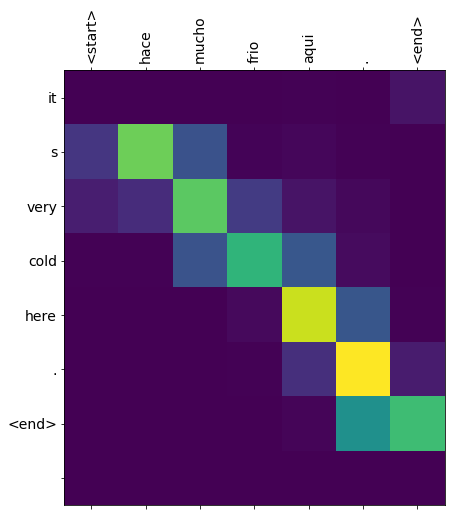

In [0]:
translate(u"hace mucho frio aqui.")

Input: <start> ¿ todavia estan en casa ? <end>
Translation: are you still at home ? <end> 


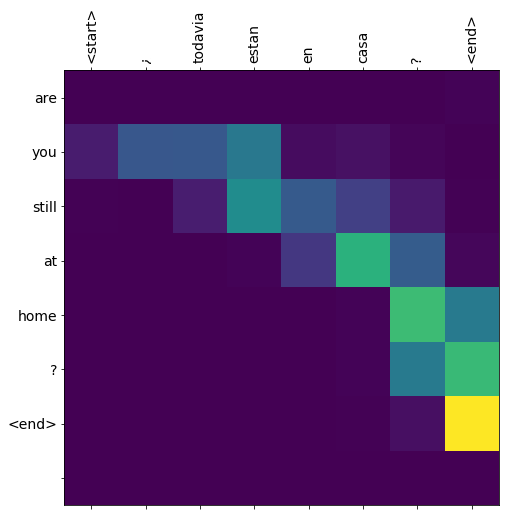

In [0]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Translation: try to figure it out . <end> 


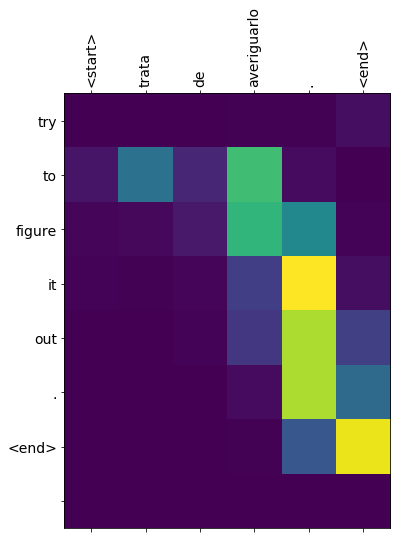

In [0]:
# wrong translation (Try to find out.)
translate(u'trata de averiguarlo.')